In [1]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image

#이미지 데이터베이스 구축을 위해 CIFAR-100 데이터셋 활용
dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/data/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

# 이미지를 저장할 하위 디렉토리를 생성 
images_dir_path = os.getenv('HOME')+'/aiffel/python_image_proc/cifar-images'
if not os.path.exists(images_dir_path):
    os.mkdir(images_dir_path) 

In [8]:
# 이미지 파일을 열어옴.
with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')
    
print(type(train))  
train.keys()

<class 'dict'>


dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [11]:
train[b'data'][0:5] 

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       [124, 131, 135, ..., 232, 236, 231],
       [ 43,  32,  87, ...,  60,  29,  37]], dtype=uint8)

In [12]:
train[b'data'][1].shape 

(3072,)

In [17]:
train[b'filenames'][0:5]

[b'bos_taurus_s_000507.png',
 b'stegosaurus_s_000125.png',
 b'mcintosh_s_000643.png',
 b'altar_boy_s_001435.png',
 b'cichlid_s_000031.png']

In [23]:
# 32X32의 이미지 파일 50000개를 생성합니다. 
for i in tqdm(range(len(train[b'filenames']))):
    filename = train[b'filenames'][i].decode() # byte를 str로 디코딩함.
    data = train[b'data'][i].reshape([32, 32, 3], order='F') # # 32 x 32 x 3으로 reshape한 후, 앞선 차원부터 데이터를 채움.
    image = Image.fromarray(data.swapaxes(0, 1)) # 이미지의 x축과 y축을 바꿔줌.
    image.save(os.path.join(images_dir_path, filename))

100%|██████████| 50000/50000 [01:01<00:00, 807.98it/s]


In [30]:
# 파일명을 인자로 받아 해당 이미지와 히스토그램을 출력해 주는 함수
def draw_color_histogram_from_image(file_name):
    image_path = os.path.join(images_dir_path, file_name)
    
    img = Image.open(image_path)  # 이미지 열기
    cv_image = cv2.imread(image_path) # 파일로부터 이미지를 읽어옴.

    f = plt.figure(figsize=(10,3))
    im1 = f.add_subplot(1,2,1)
    im1.imshow(img)
    im1.set_title("Image")

    im2 = f.add_subplot(1,2,2)
    color = ('b','g','r')
    for i,col in enumerate(color): # 0:blue, 1:green, 2:red
        histr = cv2.calcHist([cv_image],[i],None,[256],[0,256]) # 히스토그램 그리기
        im2.plot(histr, color = col)   #  채널 색상과 맞춰서 그림.
    im2.set_title("Histogram")

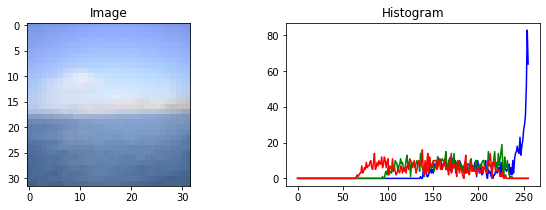

In [31]:
draw_color_histogram_from_image('adriatic_s_001807.png') # 파란색이 가장 많이 쓰임.

In [39]:
# 이미지 파일 1개에 대해 히스토그램을 만드는 함수
def get_histogram(image):  
    histogram = []

    for i in range(3):
        channel_histogram = cv2.calcHist(images=[image],
                                         channels=[i], #채널별 히스토그램을 생성함.
                                         mask=None,
                                         histSize=[4],  # 히스토그램의 구간을 4개로 함.
                                         ranges=[0, 256])
        histogram.append(channel_histogram)  

    histogram = np.concatenate(histogram)
    histogram = cv2.normalize(histogram, histogram)

    return histogram 

In [40]:
def build_histogram_db():
    histogram_db = {}

    path = images_dir_path
    file_list = os.listdir(images_dir_path)  # 디렉토리에 모아 둔 이미지 파일들을 전부 리스트업함.

    for file_name in tqdm(file_list):
        file_path = os.path.join(images_dir_path, file_name)
        image = cv2.imread(file_path)

        histogram = get_histogram(image)

        histogram_db[file_name] = histogram

    return histogram_db  # 이미지 이름을 key로 하고, 히스토그램을 value로 하는 딕셔너리 histogram_db를 반환

In [51]:
histogram_db = build_histogram_db()
histogram_db['adriatic_s_001807.png']

100%|██████████| 49999/49999 [03:29<00:00, 238.48it/s]


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

In [45]:
def get_target_histogram():
    filename = input("이미지 파일명을 입력하세요: ")
    if filename not in histogram_db:
        return print('유효하지 않은 이미지 파일명입니다.')
    return histogram_db[filename]

In [50]:
# CIFAR-100 히스토그램 중 입력된 이미지 이름에 해당하는 히스토그램을 입력 이미지로 선택하여 target_histogram이라는 변수명으로 지정
target_histogram = get_target_histogram()
target_histogram

이미지 파일명을 입력하세요: adriatic_s_001807.png


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

In [52]:
def search(histogram_db, target_histogram, top_k=5): #유사도 순서상으로 상위 5개 이미지만 선택함.
    results = {}

    # 입력 이미지와 검색 대상 이미지 하나하나의 히스토그램 간 유사도를 계산
    for file_name, histogram in tqdm(histogram_db.items()):
        distance = cv2.compareHist(H1 = target_histogram,      
                                   H2 = histogram,
                                   method = cv2.HISTCMP_CHISQR)

        results[file_name] = distance

    results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])

    return results

In [53]:
result = search(histogram_db, target_histogram)
result

100%|██████████| 49999/49999 [00:00<00:00, 156625.82it/s]


{'adriatic_s_001807.png': 0.0,
 'baby_s_001654.png': 0.047506706444185816,
 'fogbank_s_000423.png': 0.059270738493642845,
 'tank_s_000442.png': 0.060966690827361725,
 'dessert_plate_s_000124.png': 0.06113711905561663}

In [54]:
# result를 입력받아 5개의 이미지를 화면에 출력하는 함수
def show_result(result):
    f = plt.figure(figsize=(10,3))
    
    for idx, filename in enumerate(result.keys()):    
        img_path = os.path.join(images_dir_path, filename)
        
        im = f.add_subplot(1,len(result),idx+1)
        
        img = Image.open(img_path)
        im.imshow(img)

이미지 파일명을 입력하세요: stegosaurus_s_000125.png


100%|██████████| 49999/49999 [00:00<00:00, 225732.36it/s]


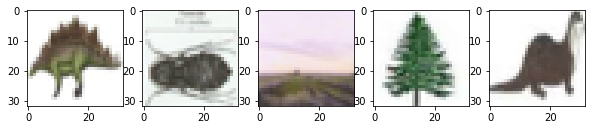

In [56]:
target_histogram = get_target_histogram()
result = search(histogram_db, target_histogram)
show_result(result)